<a href="https://colab.research.google.com/github/JairEsc/Mat_Apl/blob/main/Proyecto_DFO_ruido_problemas.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import scipy.optimize
import matplotlib.pyplot as plt

In [2]:
def L_BFGS(S,Y,g):#Checar las posibles divisiones por cero
    n=len(g)
    m=len(S)
    #supondremos H_0 un multiplo de la identidad
    H_0=(np.dot(S[-1],Y[-1])/(np.max([np.dot(Y[-1],Y[-1]),10**(-6)] )))*np.identity(n)#Dado en clase.
    q=g
    alphas=[]
    for i in range(m):
        alphas.append((1/max(10**(-6),np.dot(S[m-1-i],Y[m-1-i])))*np.dot(S[m-1-i],q))
        q=q-alphas[i]*Y[m-1-i]
    r=np.dot(H_0,q)
    for i in range(m):
        beta=(1/max(10**(-6),np.dot(Y[i],S[i])))*np.dot(Y[i],r)
        r=r+S[i]*(alphas[m-1-i]-beta)#aproximacion de -H*g
    return r
def ECNoise(F):#F es un vector que guarda f(t_i), i=0,...,m. Evaluaciones de m+1 puntos equiespaciados
#Ver metodo en Estimating_Computational_Noise, pagina 8
    m=len(F)-1
    T=np.zeros((m+1,m+1))
    for i in range(m+1):
        T[i,0]=F[i]
    for k in range(m):
        for i in range(m-k):
            T[i,k+1]=T[i+1,k]-T[i,k]
    return T
def var_estimation(T):#Recibe la tabla.
    m=len(T)-1
    sigma_array=[]
    for k in range(1,m):
        sigma_array.append(((np.math.factorial(k)/np.math.factorial(2*k))/(m+1-k))*np.sum(T.T[k]**2))
    #Ahora checamos las 2 condiciones.
    for k in range(1,m-2):
        max_k=np.max(sigma_array[k:k+2])
        min_k=np.min(sigma_array[k:k+2])
        if(max_k<=4*min_k):
            if(np.sign(min_k*max_k)==-1):
                print("es el ", k)
                break
    return np.sqrt(sigma_array[k])#Podria ser que las condiciones no se cumplan, en tal caso regresa la ultima estimacion sigma.
def aprox_f_biprima(e_f,f,x_k,p):#Usando una direccion (aleatoria dada) se aproxima el max ||Hessiana_f(x_k)*p||
    #Ver Estimating Derivatives of Noisy Simulations, pagina 14.
    tao_1=100
    tao_2=0.1
    h_a=e_f**(1/4)
    f_mas=f(x_k+h_a*p)
    f_menos=f(x_k-h_a*p)
    f_0=f(x_k)
    delta_h_a=abs(f_mas+f_menos-2*f_0)
    mu_a=delta_h_a/(np.max([h_a**2,10**(-6)]))
    if(delta_h_a/np.max([e_f,10**(-6)])>=tao_1):
        mu=mu_a
        if(abs(f_mas-f_0)<=tao_2*max(f_mas,f_menos,f_0) and abs(f_menos-f_0)<=tao_2*max(f_mas,f_menos,f_0)):
            return mu_a
    h_b=(e_f/np.max([mu_a,10**(-6)]))**(1/4)
    f_mas=f(x_k+h_b*p)
    f_menos=f(x_k-h_b*p)
    delta_h_b=abs(f_mas+f_menos-2*f_0)
    mu_b=delta_h_b/(np.max([h_b**2,10**(-6)] ))
    if(delta_h_b/np.max([e_f,10**(-6)])>=tao_1):
        mu=mu_b
        if(abs(f_mas-f_0)<=tao_2*max(f_mas,f_menos,f_0) and abs(f_menos-f_0)<=tao_2*max(f_mas,f_menos,f_0)):
            return mu_b
    if(abs(mu_a-mu_b)<=0.5*mu_b):
        return mu_b
    #print("No hay regla de decision")
    return np.max([mu_a,mu_b,10**(-6)])#Por falta de relga de descicion. En el algoritmo no se especifica una opcion.

def rutina_h(f,p,x_0,m=10):#Calcula h a partir de una direccion dada, con m+1 puntos equiespaciados.
    f_0=f(x_0)
    n=len(x_0)
    delta=10**(-3)#Suggested by ECnoise algorithm.
    F_st=[f(x_0+delta*i*p) for i in range(m)]
    T=ECNoise(F_st)
    e_f=var_estimation(T)
    #print("e_f: ",e_f)#Breakpoint
    mu=aprox_f_biprima(e_f=e_f,f=f,x_k=x_0,p=p)
    h=(8**(1/4))*(e_f/np.max([mu,10**(-6)]))**(1/2)
    return e_f,h
def relaxed_Armijo(x_k,f,fprime,d,alpha_0=1,e_f=0.0,c_1=0.1,c_2=0.9,
                   max_iter=10**2):##Intenté usar scipy.line_search(), pero Strong Wolfe son dificiles de satisfacerse
    #Metodo visto en clase.
    iter=0
    alpha=0
    grad_f_k=fprime(x_k)
    f_k=f(x_k)
    beta=np.inf
    alpha_i=alpha_0
    g_dot_d=np.dot(grad_f_k,d)
    Armijo=False
    for i in range(max_iter):
        if(f(x_k+alpha_i*d)>f_k+c_1*alpha_i*g_dot_d+2*e_f):#Aqui esta la condicion relajada, dado e_f estimacion del error estandar.
            beta=alpha_i
            alpha_i=0.5*(alpha+beta)
        else:
            Armijo=True
            if(np.dot(fprime(x_k+alpha_i*d),d)<c_2*g_dot_d):
                alpha=alpha_i
                if(beta==np.inf):
                    alpha_i=2*alpha
                else:
                    alpha_i=0.5*(alpha+beta)
            else:
                break
    if(Armijo==True):
        return alpha_i
    else:
        return Armijo

In [3]:
def recovery(x_k,f,grad_k,e_f,h,l1,l2,d_k,m=10):#Genera un nuevo h
    d_k=d_k/np.max(d_k)
    e_f_b,h_b=rutina_h(f=f,p=d_k,m=m,x_0=x_k)
    n=len(x_k)
    f_stencil=[]
    f_k=f(x_k)
    if(h_b<l1*h or h_b>l2*h):
        return x_k,e_f_b,h_b
    else:
        
        x_h=x_k+h*(d_k)
        f_h=f(x_h)
        if(f_h<=f(x_k)+0.1*h*np.dot(grad_k,d_k)+2*e_f):
            return x_h,e_f,h
        else:
            for i in range(n):
                x_s=x_k
                x_s[i]+=h
                f_stencil.append(f(x_s))
            ii=np.argmin(f_stencil)
            x_s=x_k
            x_s[ii]+=h
            f_s=f(x_s)
            if(f_h<=f_s and f_h<=f_k):
                return x_h,e_f,h
            else:
                if(f_k>f_s and f_h>f_s):
                    return x_s,e_f,h
                else:
                    e_f_n,h_n=rutina_h(f=f,p=np.random.uniform(-1,1,size=n),m=m,x_0=x_k)
                    return x_k,e_f_n,h_n

In [4]:
import copy
def CD_grad(x, fun, h=None, ret_sten=False):
    if h is None:
        h = np.max([1.0]+[np.abs(v) for v in x])*(1e-6)
    
    h = np.max([1e-6, h])
    
    f_p = np.zeros(x.shape[0])
    f_n = np.zeros(x.shape[0])
    
    for i in range(x.shape[0]):
        dum_x = copy.deepcopy(x)
        dum_x[i] += h
        f_p[i]    = fun(dum_x)
        dum_x[i] -= 2*h
        f_n[i]    = fun(dum_x)
    
    g = ( f_p - f_n )/(2*h)
    
    if ret_sten:
        min_p = np.argmin(f_p)
        min_n = np.argmin(f_n)
        s_id = min_n           #assume that min value is for min_n index
        x_s  = x[s_id] - h
        f_s  = f_n[s_id]
        if f_p[min_p] < f_n[min_n]:
            x_s = x[min_p] + h
            f_s = f_p[min_p]
        
        return g, [x_s, f_s]
        
    else:
        return g

In [5]:
def Rosembrok_grad(X):
    n=len(X)
    grad=np.zeros(n)
    grad[1:-1]=-400*X[1:-1]*(X[2:]-X[1:-1]**2)+200*(X[1:-1]-X[:-2]**2)-2*(1-X[1:-1])
    grad[0]=-400*X[0]*(X[1]-X[0]**2)-2*(1-X[0])
    grad[-1]=200*(X[-1]-X[-2]**2)
    return grad

In [6]:
import time
def find_minimum(f,x_0,tol_g=10**(-4),zeta=0.01,max_iter=10**2,alpha_max_iter=100,m=10,ml=200,f_opt=0,derivative_dif='FD',stop_crit='grad',h_bound=10**(-6),plot=False):
    t1 = time.time()
    n=len(x_0)
    #----------------------
    #Listas
    iter=0
    GG=[]
    Y=[]
    S=[]
    FF=[abs(f(x_0)-f_opt)]
    #----------------------
    #Primera iteracion para crear S_k, Y_k------------------------
    e_f,h=rutina_h(f=f,p=np.random.uniform(-1,1,size=len(x_0)),m=m,x_0=x_0)
    def fprime(x):
        if(derivative_dif=='FD'):
            return CD_grad(x, fun=f, h=np.max([h,h_bound]), ret_sten=False)
        else:
            if(derivative_dif=='CD'):
                return scipy.optimize.approx_fprime(xk=x,f=f,epsilon=np.max([h,h_bound]))
    g_0=fprime(x_0)#Gradiente
    alpha_k=relaxed_Armijo(f=f,fprime=fprime,x_k=x_0,d=-g_0,e_f=e_f,max_iter=alpha_max_iter)#line_search
    x_1=x_0-alpha_k*g_0#Primera direccion de descenso es -grad(x_0)
    g_1=fprime(x_1)
    GG.append(np.linalg.norm(g_1))
    #---------------------- 
    Y.append(g_1-g_0)#diferencia de gradientes
    S.append(-alpha_k*g_0)#diferencia de x's
    FF.append(abs(f(x_1)-f_opt))#Meta-Convergencia
    #----------------------
    nonstop_criteria=True
    while(nonstop_criteria and iter<max_iter):#Criterio de paro
        x_0=x_1
        g_0=g_1
        d_k=-L_BFGS(S=S,Y=Y,g=g_1)
        if(iter>ml and len(Y)>ml-10):#Elimina los viejos s_k,y_k
            del S[0]
            del Y[0]
        alpha_k_try=relaxed_Armijo(f=f,fprime=fprime,x_k=x_0,d=d_k,e_f=e_f,max_iter=alpha_max_iter)
        if(alpha_k_try==False):
            x_1,e_f,h=recovery(x_k=x_0,f=f,grad_k=g_1,e_f=e_f,h=h,l1=0.01,l2=100,d_k=d_k,m=12)
            def fprime(x):
                if(derivative_dif=='FD'):
                    return CD_grad(x, fun=f, h=np.max([h,h_bound]), ret_sten=False)
                else:
                    if(derivative_dif=='CD'):
                        return scipy.optimize.approx_fprime(xk=x,f=f,epsilon=np.max([h,h_bound]))
        else:
            x_1=x_0+alpha_k*d_k#Actualizacion
        g_1=fprime(x_1)
        if(stop_crit=='grad'):
            nonstop_criteria=np.linalg.norm(g_1)>tol_g
        else:
            nonstop_criteria=abs((f(x_1)-f(x_0))/np.max([1,f(x_0)]))>tol_g
        iter+=1
        #H_k=H_k_m
        y_k=g_1-g_0
        s_k=x_1-x_0
        if(np.dot(s_k,y_k)>=zeta*np.linalg.norm(y_k)*np.linalg.norm(s_k)):
            Y.append(y_k)
            S.append(s_k)
        GG.append(np.linalg.norm(g_1))
        FF.append(abs(f(x_1)-f_opt))
    if(plot):
        plt.plot(FF)
        plt.title(r'k vs. $|f(x_k)-f(x^*)|$')
        plt.show()
    print("Summary: ")    
    t2 = time.time()
    tim = t2-t1
    niter = iter
    print("time: {:.02e}\t Niter: {} \t ||g_k||: {:.02e} ".format(
             tim,niter,GG[-1]))
    return x_1

In [7]:
def find_minimum_Rosembrok(x_0,f,grad_f=Rosembrok_grad,tol=10**(-3),zeta=0.01,max_iter=10**3,f_opt=0,stop_crit='grad',plot=False):
    t1 = time.time()
    n=len(x_0)
    iter=0
    alpha_max_iter=100
    GG=[]
    Y=[]
    S=[]
    FF=[abs(f(x_0)-f_opt)]
    g_0=grad_f(x_0)#Gradiente
    alpha_k=relaxed_Armijo(f=f,fprime=grad_f,x_k=x_0,d=-g_0,e_f=0,max_iter=alpha_max_iter)#line_search
    x_1=x_0-alpha_k*g_0#Primera direccion de descenso es -grad(x_0)
    g_1=grad_f(x_1)
    GG.append(np.linalg.norm(g_1))
    #---------------------- 
    Y.append(g_1-g_0)#diferencia de gradientes
    S.append(-alpha_k*g_0)#diferencia de x's
    FF.append(abs(f(x_1)-f_opt))#Meta-Convergencia
    #----------------------
    nonstop_criteria=True
    while(nonstop_criteria and iter<max_iter):#Criterio de paro
        x_0=x_1
        g_0=g_1
        d_k=-L_BFGS(S=S,Y=Y,g=g_1)
        if(iter>100 and len(Y)>100-10):#Elimina los viejos s_k,y_k
            del S[0]
            del Y[0]
        alpha_k_try=relaxed_Armijo(f=f,fprime=grad_f,x_k=x_0,d=d_k,e_f=0,max_iter=alpha_max_iter)
        if(alpha_k_try!=False):
            alpha_k=alpha_k_try
        
        x_1=x_0+alpha_k*d_k#Actualizacion
        g_1=grad_f(x_1)
        if(stop_crit=='grad'):
            nonstop_criteria=np.linalg.norm(g_1)>tol
        else:
            nonstop_criteria=abs((f(x_1)-f(x_0))/np.max([1,f(x_0)]))>tol
        iter+=1
        #H_k=H_k_m
        y_k=g_1-g_0
        s_k=x_1-x_0
        if(np.dot(s_k,y_k)>=zeta*np.linalg.norm(y_k)*np.linalg.norm(s_k)):
            Y.append(y_k)
            S.append(s_k)
        GG.append(np.linalg.norm(g_1))
        FF.append(abs(f(x_1)-f_opt))
    print("Summary: ")
    if(plot):
        plt.plot(GG)
        #plt.title(r'k vs. $|f(x_k)-f(x^*)|$')
        plt.title(r'k vs. $||\nabla f(x_k)||$')
        plt.show()
    t2 = time.time()
    tim = t2-t1
    niter = iter
    print("time: {:.02e}\t Niter: {} \t ||g_k||: {:.02e} ".format(
             tim,niter,GG[-1]))
    return x_1


------------------------
Rosembrok dimension  5

Ruido Aditivo $\sim U($ -0.1 , 0.1 )
Summary: 
time: 3.48e-02	 Niter: 28 	 ||g_k||: 2.00e-04 

Ruido Aditivo $\sim U($ -0.01 , 0.01 )
Summary: 
time: 3.57e-02	 Niter: 43 	 ||g_k||: 2.18e-04 

Ruido Aditivo $\sim U($ -0.0001 , 0.0001 )
Summary: 
time: 3.05e-02	 Niter: 40 	 ||g_k||: 7.90e-04 

------------------------
Rosembrok dimension  10

Ruido Aditivo $\sim U($ -0.1 , 0.1 )
Summary: 
time: 4.31e-02	 Niter: 36 	 ||g_k||: 4.24e-04 

Ruido Aditivo $\sim U($ -0.01 , 0.01 )
Summary: 
time: 2.93e-02	 Niter: 38 	 ||g_k||: 4.96e-04 

Ruido Aditivo $\sim U($ -0.0001 , 0.0001 )
Summary: 
time: 6.05e-02	 Niter: 72 	 ||g_k||: 7.41e-04 

------------------------
Rosembrok dimension  20

Ruido Aditivo $\sim U($ -0.1 , 0.1 )
Summary: 
time: 1.02e-01	 Niter: 90 	 ||g_k||: 4.98e-04 

Ruido Aditivo $\sim U($ -0.01 , 0.01 )
Summary: 
time: 4.22e-02	 Niter: 48 	 ||g_k||: 6.60e-04 

Ruido Aditivo $\sim U($ -0.0001 , 0.0001 )
Summary: 
time: 2.28e-02	 Nit

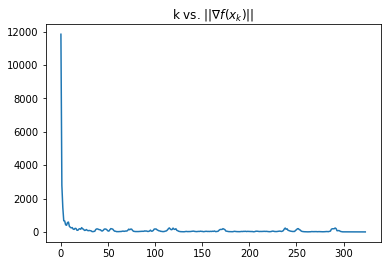

time: 2.48e+00	 Niter: 323 	 ||g_k||: 8.83e-04 

Ruido Aditivo $\sim U($ -0.01 , 0.01 )
Summary: 


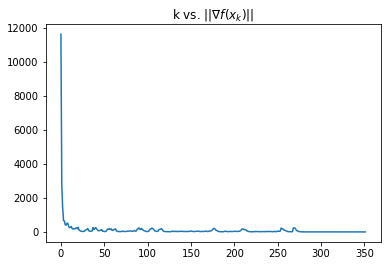

time: 2.77e+00	 Niter: 351 	 ||g_k||: 7.65e-04 

Ruido Aditivo $\sim U($ -0.0001 , 0.0001 )
Summary: 


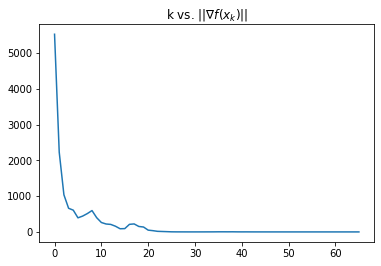

time: 5.85e-01	 Niter: 65 	 ||g_k||: 9.82e-04 


In [8]:
#Muestra de que una buena aproximacion del gradiente es suficiente para un buen comportamiento.
plot=False
for n in [5,10,20,50,100,200,500]:
    if(n==500):
        plot=True
    print("\n------------------------")
    print("Rosembrok dimension ", n)
    for eps in [10**(-1),10**(-2),10**(-4)]:
        print("\nRuido Aditivo",r'$\sim U($',-eps,",",eps,")")
        def Rosembrok_ruido(X):#X es un vector.
            return (np.sum(100*(X[1:]-X[:-1]**2)**2+(1-X[:-1])**2)+eps*np.random.uniform(0,1))#Ruido
    
        x_0=np.random.uniform(0,2,size=n)
        x_opt=find_minimum_Rosembrok(x_0,f=Rosembrok_ruido,grad_f=Rosembrok_grad,tol=10**(-3),zeta=0.01,max_iter=5*10**3,f_opt=0,stop_crit='grad',plot=plot)

In [9]:
def p_204(X):#x_0=np.array([0.1,0.1] ), x_opt=np.array([0,0] )
    A=np.array([0.13294 ,-0.244378, 0.325895] )
    D=np.array([2.5074 ,-1.36401,1.02282] )
    H=np.array([[-0.564255 ,0.392417], [ -0.404979, 0.927589], [-0.0735084 ,0.535493]] )
    B=np.linalg.inv(np.dot(H.T,H))
    W=A+np.dot(H,X)+0.5*np.dot(X,np.dot(B,X))*D
    return np.dot(W,W)+np.random.uniform(-10**(-2),10**(-2))

In [10]:
def p_205(X):#x_0=np.array([0.1,0.] ), x_opt=np.array([3,0.5] )
    return ((1.5-X[0]*(1-X[1]))**2+(2.25-X[0]*(1-X[1]**2))**2+(2.625-X[0]*(1-X[1]**3))**2)


In [11]:
def p_206(X):#x_0=[-1.2,1], x_opt=[1,1]
    return ((X[1]-X[0]**2)**2+100*(1-X[0])**2)

In [12]:
def p_212(X):#x_0=[2,0], x_opt=[0,0]
    return (((4*(X[0]+X[1]))**2+(4*(X[0]+X[1])+(X[0]-X[1])*((X[0]-2)**2+X[1]**2-1))**2))


In [13]:
def p_214(X):#x_0=[-1.2,1], x_opt=[1,1]
    return ((10*(X[0]-X[1])**2+(X[0]-1)**2)**(1/4))

In [14]:
def p_271(X):#x_0=np.array([0,0,0,0,0,0]),x_opt=np.array([1,1,1,1,1,1])
    suma=0
    for i in range(1,len(X)+1):
        suma+=(16-i)*(X[i-1]-1)**2
    return 10*suma

In [15]:
def p_276(X):#x_0=np.array([-4,-2,-1.333,-1,-0.8,-0.6667]), x_opt=np.zeros(6)
    n=len(X)
    X=np.array(X)
    A=np.zeros((n,n))
    for i in range(n):
        for j in range(n):
            if(i+j!=1):
                A[i,j]=1/(i+j+1)
    return np.dot(X,np.dot(A,X))

In [16]:
def p_281(X):#x_0=np.array([0,0,0,0,0,0,0,0,0,0]), x_opt=np.ones(10)
    suma=0
    for i in range(1,len(X)+1):
        suma+=(i**3)*(X[i-1]-1)**2
    return suma**(1/3)

In [17]:
def p_282(X):#x_0=[-1.2,0,0,0,0,0,0,0,0,0], x_opt=np.ones(10)
    sum=0
    for i in range(1,len(X)):
        sum+=(10-i)*(X[i-1]**2-X[i])**2
    return (X[0]-1)**2+(X[9]-1)**2+10*sum

In [18]:
def p_283(X):#x_0=np.zeros(10), x_opt=np.ones(10)
    sum=0
    for i in range(1,len(X)+1):
        sum+=(i**3)*(X[i-1]-1)**2
    return sum**3


In [19]:
def p_303(X):#x_0=np.ones(20)*0.1, x_opt=np.zeros(20)
    sum_1=0
    sum_2=0
    sum_3=0
    for i in range(1,len(X)+1):
        sum_1+=X[i-1]**2
        sum_2+=0.5*i*X[i-1]
    return sum_1+sum_2**2+sum_2**4

In [20]:
def p_ros(X):
    return (np.sum(100*(X[1:]-X[:-1]**2)**2+(1-X[:-1])**2))

In [21]:
def additive_noise(f,x,eps=10**(-2),label='stochastic'):
    if(label=='stochastic'):
        u=np.random.uniform(-eps,eps)
    return(f(x)+u)
def multiplicative_noise(f,x,eps=10**(-2),label='stochastic'):
    if(label=='stochastic'):
        u=np.random.uniform(-eps,eps)
    return(f(x)*(1+u))

In [22]:
def f_noise(f,x,eps,noise):
        if(noise=='additive'):
            return additive_noise(f=f,eps=eps,x=x)
        if(noise=='multiplicative'):
            return multiplicative_noise(f=f,eps=eps,x=x)

In [24]:
#Funciones de prueba con ruido.
funciones=[p_204,p_205,p_206,p_212,p_271,p_276,p_281,p_282,p_283,p_303,p_ros]
x_initial=np.array([np.array([0.1,0.1] ),np.array([0.1,0.] ),[-1.2,1],[2,0],np.array([0,0,0,0,0,0]),np.array([-4,-2,-1.333,-1,-0.8,-0.6667]),np.array([0,0,0,0,0,0,0,0,0,0]),[-1.2,0,0,0,0,0,0,0,0,0],np.zeros(10), np.ones(20)*0.1, np.zeros(50) ],dtype=object)
x_optims=np.array([[0,0],[3,0.5],[1,1],[0,0] ,np.array([1,1,1,1,1,1]),np.zeros(6),np.ones(10),np.ones(10),np.ones(10),np.zeros(20),np.ones(50)],dtype=object)
noise_type=['additive','multiplicative']
for i in range(len(funciones)):
    f=funciones[i]
    print("Function: ", str(f))
    x_0=x_initial[i]
    n=len(x_0)
    for noise in noise_type:
        print(noise+' Case\n')
        def f_1(x):
            return f_noise(f=f,eps=10**(-3),x=x,noise=noise)
        x_opt=find_minimum(f=f_1,x_0=np.array(x_0),tol_g=10**(-6),max_iter=3*10**3,alpha_max_iter=10,m=8,ml=200,f_opt=f(x_optims[i]),derivative_dif='CD',stop_crit='otro',h_bound=10**(-3))
        print("||x_opt-x^*||:",np.linalg.norm(x_opt-x_optims[i]))
        print("|f(x_opt)-f(x^*)|:",abs(f(x_opt)-f(x_optims[i])))
        print("--------------------------")
    print("---------------------------------")

Function:  <function p_204 at 0x7f9f527abdd0>
additive Case

Summary: 
time: 1.88e+01	 Niter: 2853 	 ||g_k||: 2.15e+00 
||x_opt-x^*||: 0.13465516436183994
|f(x_opt)-f(x^*)|: 0.15325050942139498
--------------------------
multiplicative Case

Summary: 
time: 9.56e+00	 Niter: 1946 	 ||g_k||: 2.20e+00 
||x_opt-x^*||: 0.24602437190302703
|f(x_opt)-f(x^*)|: 0.6401503834776149
--------------------------
---------------------------------
Function:  <function p_205 at 0x7f9f521d5170>
additive Case

Summary: 
time: 1.72e-01	 Niter: 122 	 ||g_k||: 1.15e+00 
||x_opt-x^*||: 0.03493132699582826
|f(x_opt)-f(x^*)|: 0.0009309954328577103
--------------------------
multiplicative Case

Summary: 
time: 4.96e-02	 Niter: 58 	 ||g_k||: 1.28e-03 
||x_opt-x^*||: 0.30581028138704824
|f(x_opt)-f(x^*)|: 0.021112511277950385
--------------------------
---------------------------------
Function:  <function p_206 at 0x7f9f521d58c0>
additive Case

Summary: 
time: 1.37e+00	 Niter: 556 	 ||g_k||: 2.71e+01 
||x_opt-x^

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:36: RuntimeWarning: overflow encountered in double_scalars


Summary: 
time: 2.69e-01	 Niter: 128 	 ||g_k||: 2.69e+00 
||x_opt-x^*||: 7.373795076336984
|f(x_opt)-f(x^*)|: 9.240195213910377
--------------------------
multiplicative Case

Summary: 
time: 2.03e+00	 Niter: 580 	 ||g_k||: 3.28e+02 
||x_opt-x^*||: 5371.016238042085
|f(x_opt)-f(x^*)|: 1908.583410934844
--------------------------
---------------------------------
Function:  <function p_282 at 0x7f9f52135050>
additive Case

Summary: 
time: 2.19e-01	 Niter: 102 	 ||g_k||: 1.11e+02 
||x_opt-x^*||: 3.035564525559687
|f(x_opt)-f(x^*)|: 22.14048723999502
--------------------------
multiplicative Case

Summary: 
time: 1.12e+01	 Niter: 2411 	 ||g_k||: 8.61e+01 
||x_opt-x^*||: 2.7954516216451526
|f(x_opt)-f(x^*)|: 15.195750580549571
--------------------------
---------------------------------
Function:  <function p_283 at 0x7f9f52135290>
additive Case

Summary: 
time: 4.99e-03	 Niter: 1 	 ||g_k||: 7.71e+10 
||x_opt-x^*||: 3.1622776601683795
|f(x_opt)-f(x^*)|: 27680640625.0
----------------------

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in true_divide
  


Summary: 
time: 3.27e+00	 Niter: 924 	 ||g_k||: 5.26e+10 
||x_opt-x^*||: 3.08485995939825
|f(x_opt)-f(x^*)|: 23230775550.517498
--------------------------
---------------------------------
Function:  <function p_303 at 0x7f9f52135440>
additive Case

Summary: 
time: 7.32e-03	 Niter: 1 	 ||g_k||: 1.25e+05 
||x_opt-x^*||: 0.4473382879927521
|f(x_opt)-f(x^*)|: 12278.548846206706
--------------------------
multiplicative Case

Summary: 
time: 1.44e+01	 Niter: 3000 	 ||g_k||: 8.02e+07 
||x_opt-x^*||: 4.076687911853355
|f(x_opt)-f(x^*)|: 69599035.35518637
--------------------------
---------------------------------
Function:  <function p_ros at 0x7f9f5480fef0>
additive Case

Summary: 
time: 1.09e-01	 Niter: 17 	 ||g_k||: 8.88e+00 
||x_opt-x^*||: 7.006428527716219
|f(x_opt)-f(x^*)|: 48.51891133683652
--------------------------
multiplicative Case

Summary: 
time: 5.33e-01	 Niter: 102 	 ||g_k||: 2.61e+02 
||x_opt-x^*||: 7.0510562774342995
|f(x_opt)-f(x^*)|: 48.762135022378295
------------------

Function:  <function p_204 at 0x7f9f527abdd0>
additive Case



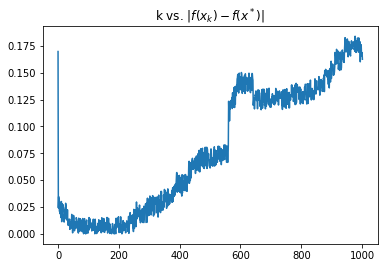

Summary: 
time: 5.18e+00	 Niter: 1000 	 ||g_k||: 3.19e+00 
||x_opt-x^*||: 0.13582587950682837
|f(x_opt)-f(x^*)|: 0.16786533340921878
--------------------------
multiplicative Case



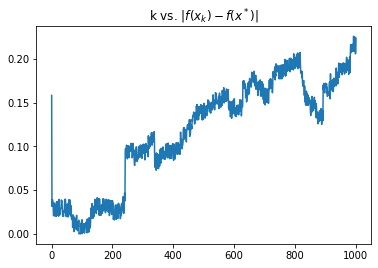

Summary: 
time: 4.99e+00	 Niter: 1000 	 ||g_k||: 3.86e+00 
||x_opt-x^*||: 0.20655662046667064
|f(x_opt)-f(x^*)|: 0.21815991433629398
--------------------------
---------------------------------
Function:  <function p_205 at 0x7f9f521d5170>
additive Case



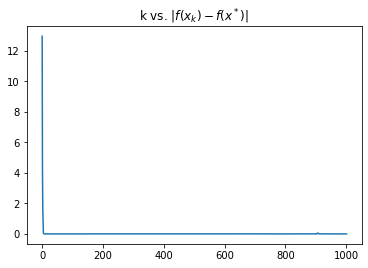

Summary: 
time: 2.80e+00	 Niter: 1000 	 ||g_k||: 3.46e-01 
||x_opt-x^*||: 0.06036773822030997
|f(x_opt)-f(x^*)|: 0.0012625398245994935
--------------------------
multiplicative Case



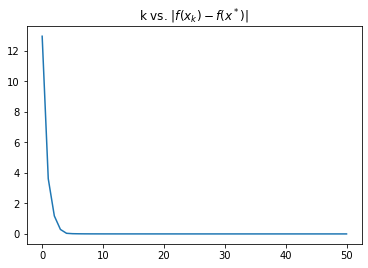

Summary: 
time: 1.72e-01	 Niter: 49 	 ||g_k||: 7.24e-04 
||x_opt-x^*||: 0.016894139784098768
|f(x_opt)-f(x^*)|: 4.7846674527951034e-05
--------------------------
---------------------------------
Function:  <function p_206 at 0x7f9f521d58c0>
additive Case



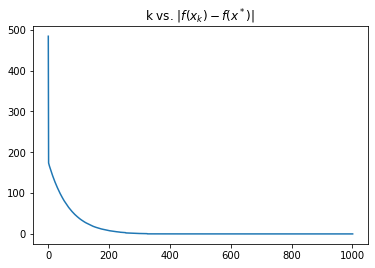

Summary: 
time: 2.83e+00	 Niter: 1000 	 ||g_k||: 2.38e+00 
||x_opt-x^*||: 0.19973994764153893
|f(x_opt)-f(x^*)|: 0.04032602826605069
--------------------------
multiplicative Case



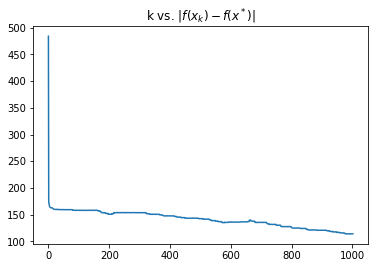

Summary: 
time: 2.69e+00	 Niter: 1000 	 ||g_k||: 2.02e+02 
||x_opt-x^*||: 1.0227975540496606
|f(x_opt)-f(x^*)|: 114.2105359160935
--------------------------
---------------------------------
Function:  <function p_212 at 0x7f9f521d5b00>
additive Case



/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in true_divide
  


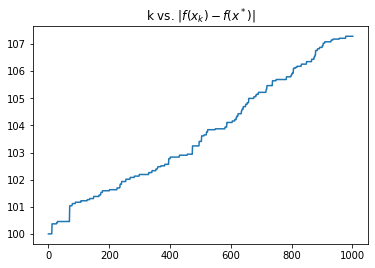

Summary: 
time: 2.97e+00	 Niter: 1000 	 ||g_k||: 1.71e+02 
||x_opt-x^*||: 2.0439601670525733
|f(x_opt)-f(x^*)|: 107.29051094080161
--------------------------
multiplicative Case



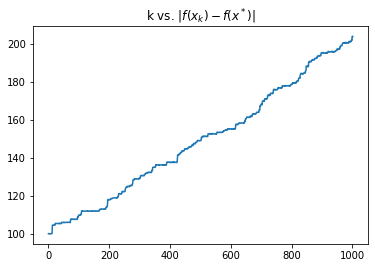

Summary: 
time: 2.96e+00	 Niter: 1000 	 ||g_k||: 2.59e+02 
||x_opt-x^*||: 2.4851752842880406
|f(x_opt)-f(x^*)|: 204.13972960501218
--------------------------
---------------------------------
Function:  <function p_271 at 0x7f9f521994d0>
additive Case



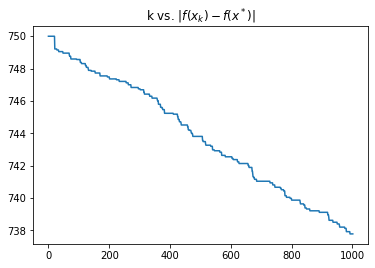

Summary: 
time: 3.30e+00	 Niter: 1000 	 ||g_k||: 6.17e+02 
||x_opt-x^*||: 2.4288567616838517
|f(x_opt)-f(x^*)|: 737.7753915999151
--------------------------
multiplicative Case



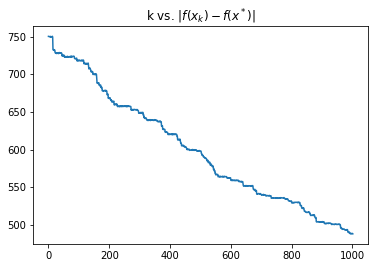

Summary: 
time: 3.34e+00	 Niter: 1000 	 ||g_k||: 5.17e+02 
||x_opt-x^*||: 1.9652053033699521
|f(x_opt)-f(x^*)|: 488.2773069457514
--------------------------
---------------------------------
Function:  <function p_276 at 0x7f9f52199830>
additive Case



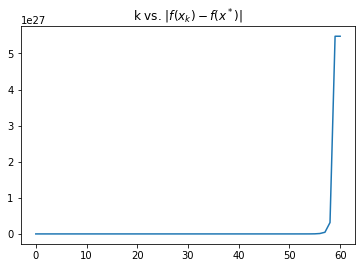

Summary: 
time: 3.56e-01	 Niter: 59 	 ||g_k||: 0.00e+00 
||x_opt-x^*||: 421790493654743.0
|f(x_opt)-f(x^*)|: 5.476723146505638e+27
--------------------------
multiplicative Case



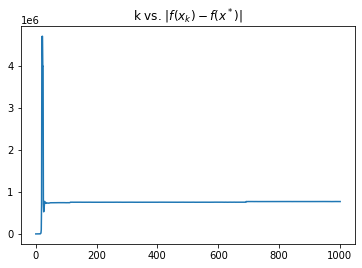

Summary: 
time: 4.02e+00	 Niter: 1000 	 ||g_k||: 8.48e+04 
||x_opt-x^*||: 3679.8295516889093
|f(x_opt)-f(x^*)|: 771779.8908048673
--------------------------
---------------------------------
Function:  <function p_281 at 0x7f9f52199710>
additive Case



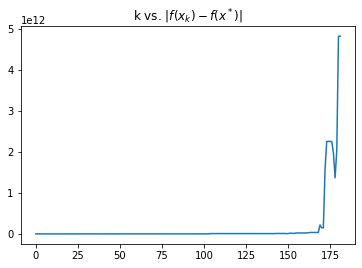

Summary: 
time: 7.44e-01	 Niter: 180 	 ||g_k||: 5.74e-04 
||x_opt-x^*||: 7.976587052953229e+17
|f(x_opt)-f(x^*)|: 4815909658636.65
--------------------------
multiplicative Case



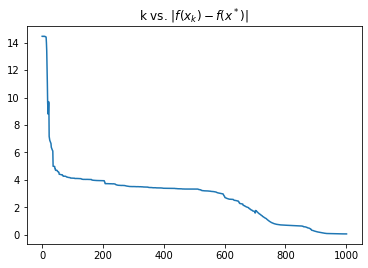

Summary: 
time: 4.13e+00	 Niter: 1000 	 ||g_k||: 3.35e-01 
||x_opt-x^*||: 0.001050618817012861
|f(x_opt)-f(x^*)|: 0.0670074940790483
--------------------------
---------------------------------
Function:  <function p_282 at 0x7f9f52135050>
additive Case



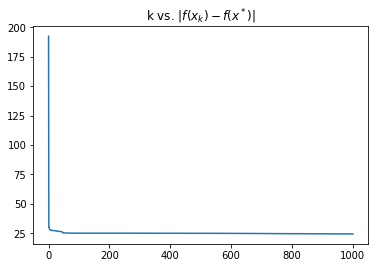

Summary: 
time: 6.42e+00	 Niter: 1000 	 ||g_k||: 1.21e+02 
||x_opt-x^*||: 3.0323603613569436
|f(x_opt)-f(x^*)|: 24.45653393865886
--------------------------
multiplicative Case



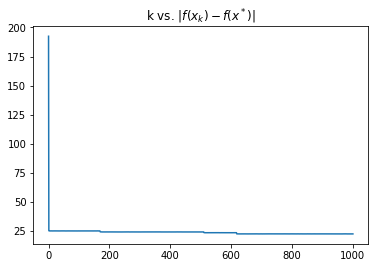

Summary: 
time: 6.27e+00	 Niter: 1000 	 ||g_k||: 1.19e+02 
||x_opt-x^*||: 3.092414975207096
|f(x_opt)-f(x^*)|: 22.72258338167898
--------------------------
---------------------------------
Function:  <function p_283 at 0x7f9f52135290>
additive Case



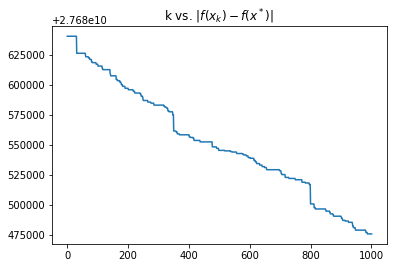

Summary: 
time: 4.06e+00	 Niter: 1000 	 ||g_k||: 7.72e+10 
||x_opt-x^*||: 3.1622750651306744
|f(x_opt)-f(x^*)|: 27680475764.053516
--------------------------
multiplicative Case



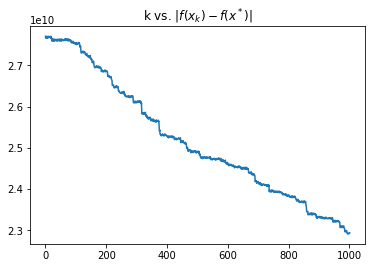

Summary: 
time: 4.08e+00	 Niter: 1000 	 ||g_k||: 2.33e+11 
||x_opt-x^*||: 3.0791498118619076
|f(x_opt)-f(x^*)|: 22932983931.916367
--------------------------
---------------------------------
Function:  <function p_303 at 0x7f9f52135440>
additive Case



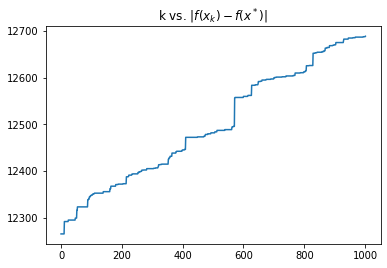

Summary: 
time: 6.11e+00	 Niter: 1000 	 ||g_k||: 1.28e+05 
||x_opt-x^*||: 0.45121566067486807
|f(x_opt)-f(x^*)|: 12689.060657770402
--------------------------
multiplicative Case



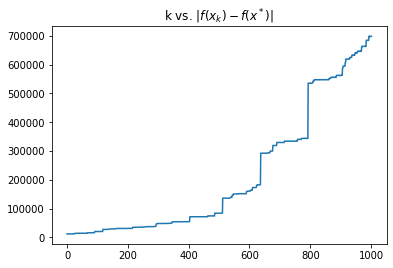

Summary: 
time: 6.08e+00	 Niter: 1000 	 ||g_k||: 2.60e+06 
||x_opt-x^*||: 1.2739319799441349
|f(x_opt)-f(x^*)|: 698287.0932033658
--------------------------
---------------------------------
Function:  <function p_ros at 0x7f9f5480fef0>
additive Case



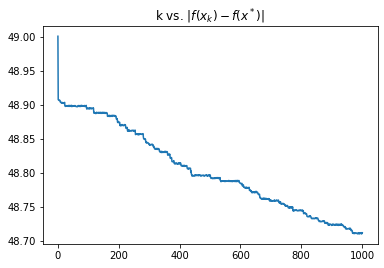

Summary: 
time: 1.31e+01	 Niter: 1000 	 ||g_k||: 1.88e+01 
||x_opt-x^*||: 7.022017408172246
|f(x_opt)-f(x^*)|: 48.71095279324335
--------------------------
multiplicative Case



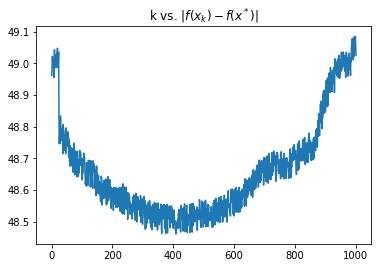

Summary: 
time: 9.68e+00	 Niter: 1000 	 ||g_k||: 8.66e+02 
||x_opt-x^*||: 6.922354898672986
|f(x_opt)-f(x^*)|: 49.03725720449029
--------------------------
---------------------------------


In [26]:
#Funciones de prueba con ruido.
funciones=[p_204,p_205,p_206,p_212,p_271,p_276,p_281,p_282,p_283,p_303,p_ros]
x_initial=np.array([np.array([0.1,0.1] ),np.array([0.1,0.] ),[-1.2,1],[2,0],np.array([0,0,0,0,0,0]),np.array([-4,-2,-1.333,-1,-0.8,-0.6667]),np.array([0,0,0,0,0,0,0,0,0,0]),[-1.2,0,0,0,0,0,0,0,0,0],np.zeros(10), np.ones(20)*0.1, np.zeros(50) ],dtype=object)
x_optims=np.array([[0,0],[3,0.5],[1,1],[0,0] ,np.array([1,1,1,1,1,1]),np.zeros(6),np.ones(10),np.ones(10),np.ones(10),np.zeros(20),np.ones(50)],dtype=object)
noise_type=['additive','multiplicative']
for i in range(len(funciones)):
    f=funciones[i]
    print("Function: ", str(f))
    x_0=x_initial[i]
    n=len(x_0)
    for noise in noise_type:
        print(noise+' Case\n')
        def f_1(x):
            return f_noise(f=f,eps=10**(-3),x=x,noise=noise)
        x_opt=find_minimum(f=f_1,x_0=np.array(x_0),tol_g=10**(-3),max_iter=10**3,alpha_max_iter=10,m=8,ml=200,f_opt=f(x_optims[i]),h_bound=10**(-5),plot=True)
        print("||x_opt-x^*||:",np.linalg.norm(x_opt-x_optims[i]))
        print("|f(x_opt)-f(x^*)|:",abs(f(x_opt)-f(x_optims[i])))
        print("--------------------------")
    print("---------------------------------")